In [ ]:
import yaml

# Открываем файл с YAML данными
with open("data.yaml", "r") as file:
    # Используем функцию load для загрузки YAML данных
    yaml_data = yaml.load(file, Loader=yaml.FullLoader)

# Выводим считанный словарь
print(yaml_data)


# Imports

In [5]:
from importlib import reload
import json
import logging
import time
from argparse import ArgumentParser
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import engine.datasets
from engine.model import CNN, MyDartsTrainer

import engine.utils
import numpy as np

# Hyperparameters

In [2]:
layers = 1
batch_size = 64
log_frequency = 40
channels = 16
unrolled = False
visualization = False

# Getting dataset

In [3]:
dataset = "cifar100"

dataset_train, dataset_valid = datasets.get_dataset(dataset)        

Files already downloaded and verified
Files already downloaded and verified


# Architecture search for a range of $\lambda$

In [4]:
logs = {}

In [5]:
def warmup_weight(epoch, epochs):
    minim, maxim = 0.1, 1
    return minim + (epoch / epochs) * (maxim - minim)

def warmup_t(epoch, epochs):
    minim, maxim = 0.05, 0.5
    return maxim - (epoch / epochs) * (maxim - minim)

weight = yes, temoreture = yes lambd = 1


c:\Users\pkbab\Documents\code\2023-Project-120\code\model.py:306: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k_left = torch.tensor((lam - left_pivot) / (right_pivot - left_pivot), device=self.device)
c:\Users\pkbab\Documents\code\2023-Project-120\code\model.py:307: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k_right = torch.tensor(1 - (lam - left_pivot) / (right_pivot - left_pivot), device=self.device)


Epoch [1/90] Step [1/391]  acc1 0.015625 (0.015625)  loss 4.603726 (4.603726)
Epoch [1/90] Step [41/391]  acc1 0.062500 (0.022104)  loss 4.564459 (4.582175)
Epoch [1/90] Step [81/391]  acc1 0.046875 (0.028549)  loss 4.311607 (4.524248)
Epoch [1/90] Step [121/391]  acc1 0.062500 (0.032929)  loss 4.281152 (4.467895)
Epoch [1/90] Step [161/391]  acc1 0.015625 (0.038432)  loss 4.189116 (4.411940)
Epoch [1/90] Step [201/391]  acc1 0.062500 (0.044232)  loss 4.166207 (4.363717)
Epoch [1/90] Step [241/391]  acc1 0.015625 (0.047783)  loss 4.209860 (4.327623)
Epoch [1/90] Step [281/391]  acc1 0.000000 (0.051991)  loss 4.271982 (4.294724)
Epoch [1/90] Step [321/391]  acc1 0.156250 (0.055783)  loss 3.844630 (4.265576)
Epoch [1/90] Step [361/391]  acc1 0.062500 (0.059384)  loss 4.099174 (4.238872)
Epoch [2/90] Step [1/391]  acc1 0.093750 (0.093750)  loss 3.742763 (3.742763)
Epoch [2/90] Step [41/391]  acc1 0.046875 (0.096799)  loss 3.906804 (3.968419)
Epoch [2/90] Step [81/391]  acc1 0.078125 (0.09

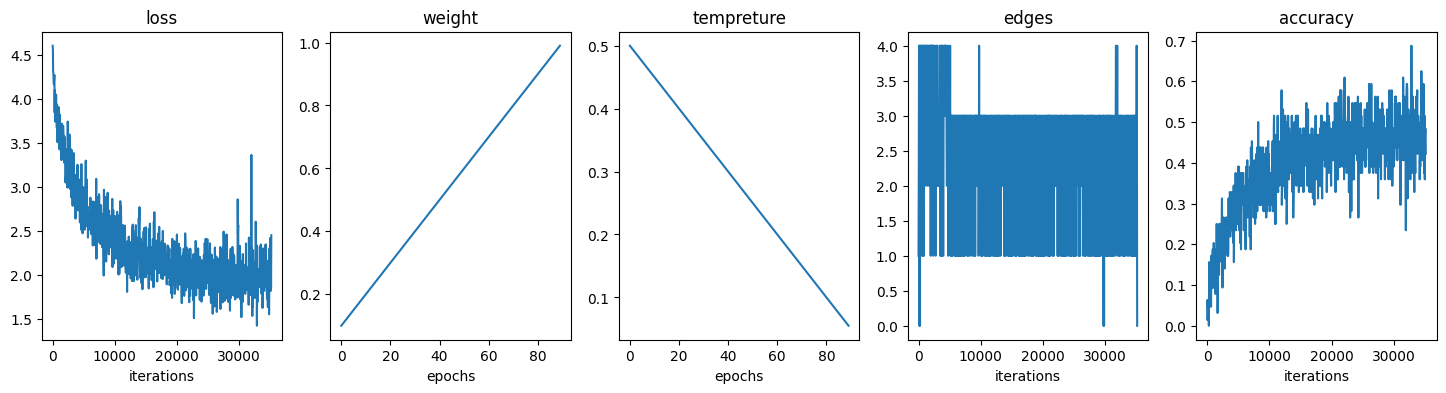

In [6]:
epochs = 90
lambd = 1
n_chosen = 1
weight = 2
wt = None
for ww in [warmup_weight]:
    for wt in [warmup_t]:
        for lambd in [1]:
            wr = utils.Writer()
            wr.new_name('loss')
            wr.new_name('weight')
            wr.new_name('tempreture')
            wr.new_name('edges')
            wr.new_name('accuracy')

            ww_label = "no" if ww is None else "yes"
            wt_label = "no" if wt is None else "yes"

            print(f"weight = {ww_label}, temoreture = {wt_label} lambd = {lambd}")
            if dataset == "fashionmnist":
                model = CNN(32, 1, channels, 10, layers, n_chosen=1)
            elif dataset == "cifar10":
                model = CNN(32, 3, channels, 10, layers, n_chosen=1)
            elif dataset == "cifar100":
                model = CNN(32, 3, channels, 100, layers, n_chosen=1)

            criterion = nn.CrossEntropyLoss() # mycriterion()
            optim = torch.optim.SGD(model.parameters(), 0.025, momentum=0.9, weight_decay=3.0E-4)
            lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, epochs, eta_min=0.001)
            trainer = MyDartsTrainer(
                model=model,
                loss=criterion, # =mycriterion,
                metrics=lambda output, target: utils.accuracy(output, target, topk=(1,)),
                optimizer=optim,
                num_epochs=epochs,
                dataset=dataset_train,
                batch_size=batch_size,
                log_frequency=log_frequency,
                unrolled=unrolled,
                weight=weight, # вес регуляризатора
                lambd=lambd, # количество общих ребер
                train_as_optimal=False,
                optimalPath='checkpoints/cifar100/optimal/arc.json',
                tau=1.0,
                learning_rate=2.5E-3,
                arc_learning_rate=5e-2,
                n_chosen=1,
                t_alpha=0.2,
                t_beta=0.2,
                turn_on_hypernetwork=True,
            )
            trainer.fit(writer=wr, warmup_t=wt, warmup_weight=ww)
            final_architecture = trainer.export()
            print('Final architecture:', final_architecture)
            if trainer.train_as_optimal:
                json.dump(trainer.export(), open(f'checkpoints/CIFAR100/optimal/arc1.json', 'w+'))
            else:
                json.dump(trainer.export(), open(f'checkpoints/CIFAR100/hypernet/arc1.json', 'w+'))
            logs.update({ f'lambd={lambd}, weight={ww_label}, tempreture={wt_label}' : wr })
            wr.show()

[0.         0.21052632 0.42105263 0.63157895 0.84210526 1.05263158
 1.26315789 1.47368421 1.68421053 1.89473684 2.10526316 2.31578947
 2.52631579 2.73684211 2.94736842 3.15789474 3.36842105 3.57894737
 3.78947368 4.        ] [0, 0, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4]


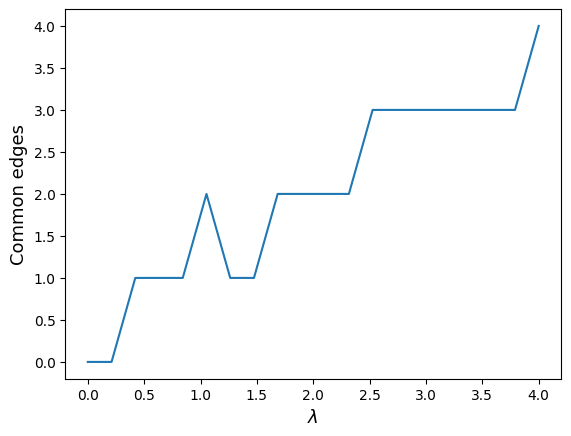

In [49]:
from utils import common_edges


edges = []
arc_optimal = trainer.checkpoint_optimum
lambdas = np.linspace(0, 4, 20)
for lam in lambdas:
    arc = trainer.get_arch(lam)
    edges.append(common_edges(arc_optimal, arc))

plt.xlabel(r'$\lambda$', fontdict=font)
plt.ylabel('Common edges', fontdict=font)
plt.plot(lambdas, edges)
print(lambdas, edges)

In [ ]:
for log in logs:
    print(log, np.mean(logs[log].get('accuracy')[1][-5:]))

lambd=1, weight=yes, tempreture=yes 0.85625
lambd=2, weight=yes, tempreture=yes 0.884375
lambd=3, weight=yes, tempreture=yes 0.88125
lambd=1, weight=yes, tempreture=no 0.878125
lambd=2, weight=yes, tempreture=no 0.88125
lambd=3, weight=yes, tempreture=no 0.884375
lambd=1, weight=no, tempreture=yes 0.9
lambd=2, weight=no, tempreture=yes 0.89375
lambd=3, weight=no, tempreture=yes 0.884375
lambd=1, weight=no, tempreture=no 0.8625
lambd=2, weight=no, tempreture=no 0.9
lambd=3, weight=no, tempreture=no 0.8875


## Common edges

In [16]:
arcs = []

with open(f'checkpoints/cifar100/optimal/arc.json') as f:
    arc = json.load(f) # оптимальная архитектура в виде словаря
    arcs.append(arc)

lambds = [1, 2, 3]
for lamb in lambds:
    with open(f'checkpoints/cifar100/random_edges/lambd={lamb}/arc4.json') as f:
        arc = json.load(f)
        arcs.append(arc)

all_intersections = []
for arc in arcs:
    intersections = []
    for other_arc in arcs:
        intersections.append(utils.common_edges(arc, other_arc))

    all_intersections.append(intersections)
intersections_with_opt = all_intersections[0]
print(intersections_with_opt)

[4, 1, 2, 3]


Text(0.5, 0, 'lambda')

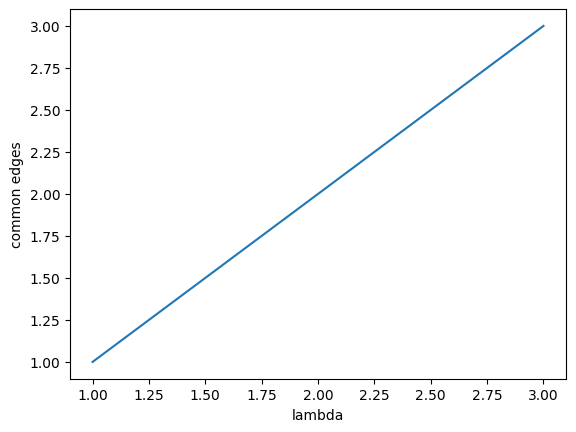

In [17]:
y = intersections_with_opt[1:]
plt.plot(lambds, y)
plt.ylabel('common edges')
plt.xlabel('lambda')

# Write archs

In [14]:
for lambd in np.linspace(0, 4, 20):
    arc = trainer.get_arch(lam)
    json.dump(arc, open(f'checkpoints/CIFAR100/hypernet/try1/arc_lam{lambd}.json', 'w'))

## Retrain

In [4]:
layers = 2
batch_size = 96
log_frequency = 20
channels = 16
unrolled = False
visualization = False
dataset = 'cifar100'

In [4]:
from retrain import train, validate, fixed_arch
# reload(train)

config = {
'layers' : layers,
'batch_size' : batch_size,
'log_frequency' : log_frequency,
'epochs' : 50,
'aux_weight' : 0.4,
'drop_path_prob' : 0.1,
'workers' : 4,
'grad_clip' : 5.,
'save_folder' : f"./checkpoints/{dataset}/",
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_train, dataset_valid = datasets.get_dataset(dataset, cutout_length=16)

best_top1s = {}
for lambd in [1, 2, 3]:
    for num in [1, 2, 3, 4]:
        if lambd == 0:
            folder = config['save_folder'] + "optimal/"
        else:
            folder = config['save_folder'] + f"random_edges/lambd={lambd}/"
        print(folder)
        with fixed_arch(folder + f'arc{1}.json'):
        # with fixed_arch(args.save_folder + "/arc.json"):
            if dataset == 'fashionMNIST':
                model = CNN(32, 1, 36, 10, config['layers'], auxiliary=True)
            if dataset == 'cifar100':
                model = CNN(32, 3, 36, 100, config['layers'], auxiliary=True)

        criterion = nn.CrossEntropyLoss()

        model.to(device)
        criterion.to(device)

        optimizer = torch.optim.SGD(model.parameters(), 0.025, momentum=0.9, weight_decay=3.0E-4)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config['epochs'], eta_min=1E-6)

        train_loader = torch.utils.data.DataLoader(dataset_train,
                                                batch_size=config['batch_size'],
                                                shuffle=True,
                                                num_workers=config['workers'],
                                                pin_memory=True)
        valid_loader = torch.utils.data.DataLoader(dataset_valid,
                                                batch_size=config['batch_size'],
                                                shuffle=False,
                                                num_workers=config['workers'],
                                                pin_memory=True)

        best_top1 = 0.
        for epoch in range(config['epochs']):
            drop_prob = config['drop_path_prob'] * epoch / config['epochs']
            model.drop_path_prob(drop_prob)

            # training
            train(config, train_loader, model, optimizer, criterion, epoch)

            # validation
            cur_step = (epoch + 1) * len(train_loader)
            top1 = validate(config, valid_loader, model, criterion, epoch, cur_step)
            best_top1 = max(best_top1, top1)

            lr_scheduler.step()

        torch.save(model.state_dict(), folder + f"mod{num}.json")
        # torch.save(model.state_dict(), args.save_folder + "/mod.json")
        print("Final best Prec@1 = {:.4%}".format(best_top1))
        best_top1s.update({f'lambd={lambd} arc{num}' : best_top1})
        print(best_top1s)

Files already downloaded and verified
Files already downloaded and verified
./checkpoints/cifar100/random_edges/lambd=1/
[2024-04-01 18:25:14] Fixed architecture: {'reduce_n2_p0': 'maxpool', 'reduce_n2_p1': 'sepconv5x5', 'reduce_n3_p0': 'sepconv5x5', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'sepconv3x3', 'reduce_n4_p0': 'dilconv3x3', 'reduce_n4_p1': 'skipconnect', 'reduce_n4_p2': 'sepconv5x5', 'reduce_n4_p3': 'sepconv5x5', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'maxpool', 'reduce_n5_p2': 'maxpool', 'reduce_n5_p3': 'sepconv5x5', 'reduce_n5_p4': 'maxpool', 'reduce_n2_switch': [0], 'reduce_n3_switch': [2], 'reduce_n4_switch': [0], 'reduce_n5_switch': [4]}
[2024-04-01 18:25:14] Epoch 0 LR 0.025000
[2024-04-01 18:25:21] Train: [  1/50] Step 000/520 Loss 6.504 Prec@(1,5) (1.0%, 7.3%)
[2024-04-01 18:25:22] Train: [  1/50] Step 020/520 Loss 6.388 Prec@(1,5) (1.8%, 8.6%)
[2024-04-01 18:25:22] Train: [  1/50] Step 040/520 Loss 6.248 Prec@(1,5) (3.0%, 12.1%)
[2024-04-01 18:25:22] Train: 

KeyboardInterrupt: 

In [1]:
for ww in ['yes', 'no']:
    for wt in ['no']:
        for l in [1, 2, 3]:
            print(ww, wt, l, best_top1s[f'lambd={l}, ww={ww}, wt={wt}'])

NameError: name 'best_top1s' is not defined

# Hypernet retrain

In [7]:
from retrain import train, validate, fixed_arch
# reload(train)

config = {
'layers' : layers,
'batch_size' : batch_size,
'log_frequency' : log_frequency,
'epochs' : 50,
'aux_weight' : 0.4,
'drop_path_prob' : 0.1,
'workers' : 4,
'grad_clip' : 5.,
'save_folder' : f"./checkpoints/{dataset}/",
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_train, dataset_valid = datasets.get_dataset(dataset, cutout_length=16)

best_top1s = {}
it = -1
for lambd in np.linspace(0, 4, 20):
    it += 1
    if it % 2 == 1 or it < 6:
        continue
    folder = f"random_edges/lambd={lambd}/"
    print(folder)
    with fixed_arch(f'checkpoints/CIFAR100/hypernet/try1/arc_lam{lambd}.json'):
    # with fixed_arch(args.save_folder + "/arc.json"):
        if dataset == 'fashionMNIST':
            model = CNN(32, 1, 36, 10, config['layers'], auxiliary=True)
        if dataset == 'cifar100':
            model = CNN(32, 3, 36, 100, config['layers'], auxiliary=True)

    criterion = nn.CrossEntropyLoss()

    model.to(device)
    criterion.to(device)

    optimizer = torch.optim.SGD(model.parameters(), 0.025, momentum=0.9, weight_decay=3.0E-4)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config['epochs'], eta_min=1E-6)

    train_loader = torch.utils.data.DataLoader(dataset_train,
                                            batch_size=config['batch_size'],
                                            shuffle=True,
                                            num_workers=config['workers'],
                                            pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(dataset_valid,
                                            batch_size=config['batch_size'],
                                            shuffle=False,
                                            num_workers=config['workers'],
                                            pin_memory=True)

    best_top1 = 0.
    for epoch in range(config['epochs']):
        drop_prob = config['drop_path_prob'] * epoch / config['epochs']
        model.drop_path_prob(drop_prob)

        # training
        train(config, train_loader, model, optimizer, criterion, epoch)

        # validation
        cur_step = (epoch + 1) * len(train_loader)
        top1 = validate(config, valid_loader, model, criterion, epoch, cur_step)
        best_top1 = max(best_top1, top1)

        lr_scheduler.step()

    torch.save(model.state_dict(), f'checkpoints/CIFAR100/hypernet/try1/mod_lam{lambd}.json')
    # torch.save(model.state_dict(), args.save_folder + "/mod.json")
    print("Final best Prec@1 = {:.4%}".format(best_top1))
    best_top1s.update({f'lambd={lambd}' : best_top1})
    print(best_top1s)

Files already downloaded and verified
Files already downloaded and verified
random_edges/lambd=1.263157894736842/
[2024-04-02 18:58:14] Fixed architecture: {'reduce_n2_p0': 'sepconv5x5', 'reduce_n2_p1': 'sepconv5x5', 'reduce_n3_p0': 'dilconv5x5', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'sepconv3x3', 'reduce_n4_p1': 'sepconv5x5', 'reduce_n4_p2': 'sepconv5x5', 'reduce_n4_p3': 'sepconv5x5', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'sepconv3x3', 'reduce_n5_p2': 'sepconv5x5', 'reduce_n5_p3': 'sepconv5x5', 'reduce_n5_p4': 'maxpool', 'reduce_n2_switch': [1], 'reduce_n3_switch': [1], 'reduce_n4_switch': [0], 'reduce_n5_switch': [4]}
[2024-04-02 18:58:14] Epoch 0 LR 0.025000
[2024-04-02 18:58:19] Train: [  1/50] Step 000/520 Loss 6.512 Prec@(1,5) (0.0%, 5.2%)
[2024-04-02 18:58:20] Train: [  1/50] Step 020/520 Loss 6.394 Prec@(1,5) (2.0%, 8.2%)
[2024-04-02 18:58:20] Train: [  1/50] Step 040/520 Loss 6.293 Prec@(1,5) (2.8%, 11.4%)
[2024-04-02 18:58:21] Train:

In [47]:
res = {'lambd=0.0' : 0.6126000193595886,'lambd=0.4210' : 0.6129000202178955, 'lambd=0.8421' : 0.613600, 'lambd=1.263157894736842': 0.6138000170707703, 'lambd=1.6842105263157894': 0.6134000166893006, 'lambd=2.1052631578947367': 0.6146000204086304, 'lambd=2.526315789473684': 0.6135000175476074, 'lambd=2.9473684210526314': 0.6146000196456909, 'lambd=3.3684210526315788': 0.6139000211715698, 'lambd=3.789473684210526': 0.6154000207901001}

Text(0.5, 0, '$\\lambda$')

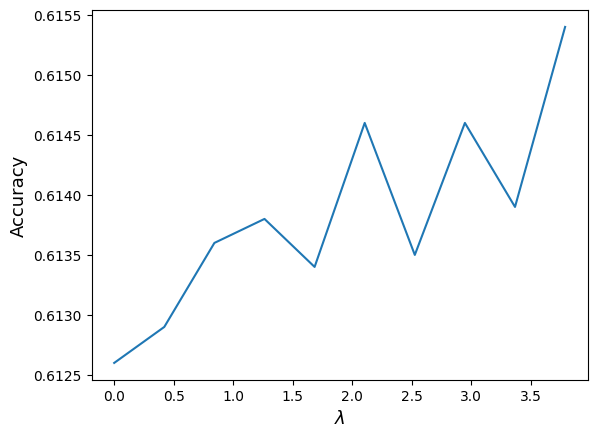

In [48]:
lambds = []
accs = []
font = { 'size' : 13 }
for lam, acc in res.items():
    lambds.append(float(lam[6:]))
    accs.append(acc)
plt.plot(lambds, accs)
plt.ylabel('Accuracy', fontdict=font)
plt.xlabel(r'$\lambda$', fontdict=font)

## Validation

In [21]:
from retrain import train, validate, fixed_arch
import numpy as np
from glob import glob
from nni.retiarii.oneshot.pytorch.utils import AverageMeter
from torch.utils.tensorboard import SummaryWriter

logger = logging.getLogger('nni')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()
n_chosen = 1

config = {
'layers' : 2,
'batch_size' : 96,
'log_frequency' : 30,
'epochs' : 10,
'aux_weight' : 0.4,
'drop_path_prob' : 0.1,
'workers' : 4,
'grad_clip' : 5.,
}

dataset_train, dataset_valid = datasets.get_dataset("cifar100", cutout_length=16)

res_dict_accur = {}
models = []

# chosen_lambdas = np.random.choice(8, size=3, replace=False) # выбранные lambda
chosen_lambdas = ['0.42105263157894735']

print(chosen_lambdas)

folder = 'checkpoints/cifar100/hypernet/try1/*'

for dir in glob(folder):
    # print(dir)
    # if dir.split('\\')[-1] != 'optimal' and dir.split('\\')[-1] != 'random' and dir.split('\\')[-1] != 'random_edges' and int(dir.split('\\')[-1].split('=')[-1]) in chosen_lambdas:
    lam = (dir.split('\\')[-1])[7:-5]
    if lam in chosen_lambdas and (dir.split('\\')[-1])[0:3] == 'arc':
        print(dir)
        with fixed_arch(folder[:-1] + f'/arc_lam{lam}.json'):
            model = CNN(32, 3, 36, 100, config['layers'], auxiliary=True, n_chosen=n_chosen)
        model.to(device)
        model.load_state_dict(torch.load(folder[:-1] + f'/mod_lam{lam}.json'))
        model.eval()
            
        models.append(model)
    elif dir.split('\\')[-1] == 'optimal' and 0 in chosen_lambdas:
        print(dir)
        folder = dir + "/"
        with fixed_arch(folder[:-1] + f'/mod_lam{lam}.json'):
            model = CNN(32, 3, 36, 100, config['layers'], auxiliary=True, n_chosen=n_chosen)
        model.to(device)
        model.load_state_dict(torch.load(folder + "mod1.json"))
        model.eval()
            
        models.append(model)
         

print(f"Models in ensemble: {len(models)}")

if len(models) != 0:
    valid_loader = torch.utils.data.DataLoader(dataset_valid,
                                                batch_size=config['batch_size'],
                                                shuffle=False,
                                                num_workers=config['workers'],
                                                pin_memory=True)
    criterion = nn.CrossEntropyLoss()

    top1 = AverageMeter("top1")
    top5 = AverageMeter("top5")
    losses = AverageMeter("losses")

    # validation
    softmax = nn.Softmax(dim=1)
    for step, (X, y) in enumerate(valid_loader):
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
            bs = X.size(0)

            probabilities = softmax(models[0](X))
            for i in range(1, len(models)):
                probabilities += softmax(models[i](X))
            probabilities = probabilities / len(models)
            loss = criterion(probabilities, y)

            accuracy = utils.accuracy(probabilities, y, topk=(1, 5))
            losses.update(loss.item(), bs)
            top1.update(accuracy["acc1"], bs)
            top5.update(accuracy["acc5"], bs)

            if step % config['log_frequency'] == 0 or step == len(valid_loader) - 1:
                logger.info(
                    "Valid: Step {:03d}/{:03d} Loss {losses.avg:.3f} "
                    "Prec@(1,5) ({top1.avg:.1%}, {top5.avg:.1%})".format(
                        step, len(valid_loader) - 1, losses=losses,
                        top1=top1, top5=top5))

    logger.info("Final best Prec@1 = {:.4%}".format(top1.avg))

    # res_dict_accur[chosen_lambdas] = top1.avg
    print(top1.avg)

Files already downloaded and verified
Files already downloaded and verified
['0.42105263157894735']
checkpoints/cifar100/hypernet/try1\arc_lam0.42105263157894735.json
[2024-04-03 21:12:59] Fixed architecture: {'reduce_n2_p0': 'sepconv5x5', 'reduce_n2_p1': 'sepconv5x5', 'reduce_n3_p0': 'dilconv5x5', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'sepconv3x3', 'reduce_n4_p1': 'sepconv5x5', 'reduce_n4_p2': 'sepconv5x5', 'reduce_n4_p3': 'sepconv5x5', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'sepconv3x3', 'reduce_n5_p2': 'sepconv5x5', 'reduce_n5_p3': 'sepconv5x5', 'reduce_n5_p4': 'maxpool', 'reduce_n2_switch': [1], 'reduce_n3_switch': [1], 'reduce_n4_switch': [0], 'reduce_n5_switch': [4]}
Models in ensemble: 1
[2024-04-03 21:13:02] Valid: Step 000/104 Loss 3.993 Prec@(1,5) (65.6%, 86.5%)
[2024-04-03 21:13:03] Valid: Step 030/104 Loss 4.047 Prec@(1,5) (60.6%, 87.4%)
[2024-04-03 21:13:03] Valid: Step 060/104 Loss 4.047 Prec@(1,5) (60.3%, 87.3%)
[2024-04-03 21:13

In [59]:
import numpy as np

# Входные значения
data = [0.5881, 0.5984, 0.6396, 0.5892, 0.6037]

# Расчет среднего значения
mean = np.mean(data)
print("Среднее значение:", mean * 100)

# Расчет дисперсии
variance = np.std(data)
print("Дисперсия:", variance * 100)


Среднее значение: 60.38
Дисперсия: 1.881733243581565
